#  <center>CHBE 552 Term Project: 
##  <center>Numerical Optimization Study of the Cathode Catalyst Layer of a PEMFC

In [1]:
# This part is for matplotlib configuration
import matplotlib as mpl

%config InlineBackend.figure_formats = ['svg']

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'mathtext.fontset': 'cm'})
mpl.rcParams.update({'axes.labelsize': 22})
mpl.rcParams.update({'axes.titlesize': 16})
mpl.rcParams.update({'axes.linewidth': 0.5})
mpl.rcParams.update({'xtick.labelsize': 10})
mpl.rcParams.update({'ytick.labelsize': 10})

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_bvp
import sys
sys.path.append("C:\2022 Winter Term 2\CHBE 552 Optimization Methods\Project\solution_algebraic_equations.py")
import solution_algebraic_equations as solalg
sys.path.append("C:\2022 Winter Term 2\CHBE 552 Optimization Methods\Project\regression.py")
import regression as reg
sys.path.append("C:\2022 Winter Term 2\CHBE 552 Optimization Methods\Project\interpolation.py")
import interpolation as inter
sys.path.append("C:\2022 Winter Term 2\CHBE 552 Optimization Methods\Project\numericalintegration.py")
import numericalintegration as numi
sys.path.append("C:\2022 Winter Term 2\CHBE 552 Optimization Methods\Project\ode_solve.py")
import ode_solve as ode
import time

## <center>  Mathematical model for the catalyst layer

### System of ODEs

Here we would like to solve the following system of ODEs:
$$
\begin{align}
\frac{dC_{O_2}}{dx} & = \frac{I(x)-I_{tot}}{nFD^{eff}_{O_2}} \\
\frac{dI}{dx} & = Ai_0^{ref}[\frac{C_{O_2}}{C_{O_2}^{ref}}exp(\frac{\alpha_cF}{RT}\eta) - exp(-\frac{\alpha_aF}{RT}\eta)] \\
\frac{d\eta}{dx} & = (\frac{1}{\sigma_{N}^{eff}}+\frac{1}{\sigma_{S}^{eff}})I(x)-\frac{1}{\sigma_{S}^{eff}}I_{tot}
\end{align}
$$
With the following boundary conditions:
1. At GDL/CL interface, x=0

$$
\begin{align}
C_{O_2}|_{x=0} & = \frac{1}{K_{O_2}} \frac{P_{O_2}}{RT}-\frac{I_{tot}L_{GDL}}{nFD_{O_2,GDL}^{eff}} \\
I|_{x=0} & = 0
\end{align}
$$

2. At CL/membrane interface, x=L

$$
\begin{align}
I|_{x=L} & = I_{tot} \\
-\frac{dC_{O_2}}{dx}|_{x=L} & = 0
\end{align}
$$

#### 1. Differential equation for oxygen concentration distribution

\begin{align}
\frac{dC_{O_2}}{dx} & = \frac{I(x)-I_{tot}}{nFD^{eff}_{O_2}}
\end{align}


where 
* $I(x)$ is the differential equation for proton current density 
* $I_{tot}$ is total current density in the catalyst layer
* $n$ is number of electrons transferred in cathode reaction
* $F$ is Faraday’s constant
* $D_{O_{2}}^{eff}$ is effective diffusion coefficient for oxygen through the catalyst layer

\begin{align}
\frac{\epsilon_{N} + \epsilon_V}{D_{O_{2}}^{eff}} &= \frac{\epsilon_N}{D_{O_{2},N}^{eff}} + \frac{\epsilon_V}{D_{O_{2},W}^{eff}} \\
\ D_{O_{2},N}^{eff} &= D_{O_{2},N}*\epsilon_N^{3/2} \\
\ D_{O_{2},W}^{eff} &= D_{O_{2},W}*\epsilon_V^{3/2} \\
\ \epsilon_V &= 1 - (\epsilon_N + \epsilon_S )\\
\ \epsilon_S &= (\frac{1}{\rho_{Pt}} + \frac{1-\%Pt}{\%Pt\rho_c})\frac{m_{Pt}}{L}
\end{align}

where
* $\epsilon_N$ is volume fraction of the Nafion in the catalyst layer
* $\epsilon_V$ is volume fraction of the void space in the catalyst layer
* $D_{O_{2},N}^{eff}$ is effective diffusion coefficients of oxygen in Nafion
* $D_{O_{2},W}^{eff}$ is effective diffusion coefficients of oxygen in water
* $D_{O_{2},N}$ is diffusion coefficient of oxygen in Nafion
* $D_{O_{2},W}$ is diffusion coefficient of oxygen in water
* $\rho_{Pt}$ is mass density of the platinum
* $\%Pt$ is mass percentage of platinum catalyst on the support carbon black
* $\rho_C$ is mass density of the carbon black
* $m_{Pt}$ is catalyst mass loading per unit area of the catalyst layer
* $L$ is thickness of the cathode catalyst layer


#### 2. Differential equation for over-potential in cathode catalyst layer

\begin{align}
\frac{d\eta}{dx} & = (\frac{1}{\sigma_{N}^{eff}}+\frac{1}{\sigma_{S}^{eff}})I(x)-\frac{1}{\sigma_{S}^{eff}}I_{tot} \\
\end{align}

where
* $\eta$ is overpotential
* $\sigma_{N}^{eff}$ is effective conductivity in Nafion
* $\sigma_{S}^{eff}$ is effective conductivity in solid catalyst partical

\begin{align}
\ \sigma_{N}^{eff} &=  \sigma_N\epsilon_{N}^{3/2}\\
\ \sigma_{S}^{eff} &=  \sigma_S\epsilon_{S}^{3/2}\\
\end{align}

where
* $\sigma_{N}$ is bulk conductivity of Nafion
* $\sigma_{S}$ is bulk conductivity of  solid catalyst (platinum + carbon)

#### 3. Differential equation for proton current density

\begin{align}
\frac{dI}{dx} & = Ai_0^{ref}[\frac{C_{O_2}}{C_{O_2}^{ref}}exp(\frac{\alpha_cF}{RT}\eta) - exp(-\frac{\alpha_aF}{RT}\eta)] \\
\ A &= A_0  \frac{m_{Pt}}{L} \\
\ i_0^{ref} &= 10^{3.507-4001/T} 
\end{align}

where
* $A$ is specific reaction surface area per volume of the catalyst layer
* $A_0$ is catalyst surface area per unit mass of the catalyst
* $i_0^{ref}$ is reference exchange current density
* $c_{O_{2}}^{ref}$ is reference oxygen concentration
* $\alpha_c$ is cathodic transfer coefficient
* $\alpha_a$ is anodic transfer coefficient
* $R$ is gas constant
* $T$ is temperature



In [2]:
# PARAMETERS AND ANALYTICAL EQUATIONS
n = 4
F = 96485
rho_Pt = 21.5
Percent_Pt = 0.2
rho_C = 2.0
m_Pt = 0.332e-3
L = 1.18e-3
epsilon_N = 0.3
epsilon_S = (1./rho_Pt + (1. - Percent_Pt)/(Percent_Pt * rho_C)) * m_Pt / L
epsilon_V = 1 - (epsilon_N + epsilon_S)
D_O2_N = 1.844e-6
D_O2_W = 3.032e-5
D_O2_W_eff = D_O2_W * epsilon_V**(3/2)
D_O2_N_eff = D_O2_N * epsilon_N**(3/2)
D_O2_eff = (epsilon_N + epsilon_V) / ((epsilon_N / D_O2_N_eff) + (epsilon_V / D_O2_W_eff))
I_tot = 0.5 
sigma_N = 0.17
sigma_S = 7.27e2
sigma_N_eff = sigma_N * epsilon_N**(3/2)
sigma_S_eff = sigma_S * epsilon_S**(3/2)

A0 = 112e4
T = 308
A = A0 * m_Pt / L
i0_ref = 10**(3.507 - 4001/T)
C_O2_ref = 1.2e-6
alpha_c = 1
alpha_a = 0.5
R = 8.315

P_O2 = 0.21
L_GDL = 100e-2
D_O2_GDL = 2.396e-1
epsilon_GDL = 0.3
D_O2_GDL_eff = D_O2_GDL * epsilon_GDL**(3/2)
K_O2 = 1/(R*T)*np.exp(-666/T + 14.1)
c_star = 1/K_O2 * (P_O2/(R*T) - (I_tot*L_GDL)/(n*F*D_O2_GDL_eff))


In [3]:
# SYSTEM OF ODEs
def dy_dx(x, y):
    # y[0] = C_O2
    # y[1] = eta
    # y[2] = I
    dCdx = (y[2] - I_tot)/(n*F*D_O2_eff)
    detadx = (1/sigma_N_eff + 1/sigma_S_eff) * y[2] - (1/sigma_S_eff) * I_tot
    dIdx = A*i0_ref*(y[0]/C_O2_ref * np.exp(alpha_c*F*y[1]/(R*T)) - np.exp(-alpha_a*F*y[1]/(R*T)))
    return np.array([dCdx, detadx, dIdx])

C:\Users\26088\AppData\Local\Temp\ipykernel_25576\3007330174.py:13: RuntimeWarning: overflow encountered in exp
  dIdx = A*i0_ref*(y[0]/C_O2_ref * np.exp(alpha_c*F*y[1]/(R*T)) - np.exp(-alpha_a*F*y[1]/(R*T)))


,Iteration,$ a $,$ b $,$ x_r $,$ f(x_r) $,$ \epsilon_r $
0,0,-10,100,45,inf,49.7822945
1,1,-10,45,17.5,inf,0.6111111111
2,2,-10,17.5,3.75,-0.3415458845,0.7857142857
3,3,3.75,17.5,10.625,inf,1.833333333
4,4,3.75,10.625,7.1875,-0.1907767567,0.3235294118
5,5,7.1875,10.625,8.90625,inf,0.2391304348
6,6,7.1875,8.90625,8.046875,-0.1359249298,0.09649122807
7,7,8.046875,8.90625,8.4765625,-0.07620739406,0.05339805825
8,8,8.4765625,8.90625,8.69140625,0.1082850583,0.02534562212
9,9,8.4765625,8.69140625,8.583984375,-0.03926514687,0.01235955056


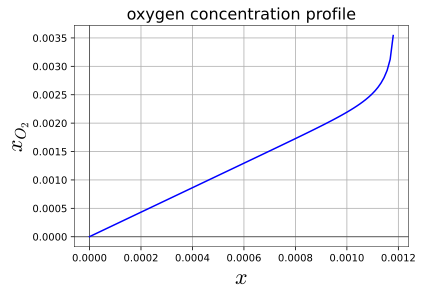

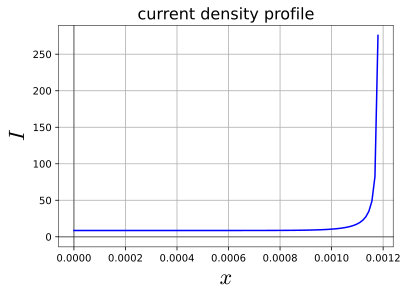

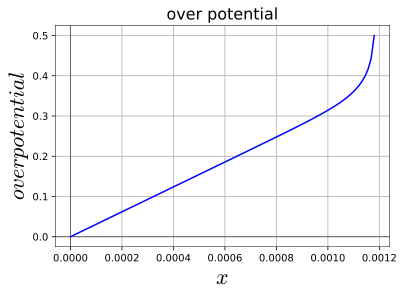

In [4]:
# Method 1: Use the shooting method combined with root finding method
n = 100 # number of intervals
npts = n + 1 # number of points
numx = np.linspace(0, L, npts)

# SYSTEM OF ODEs
def dy_dx(x, y):
    # y[0] = C_O2
    # y[1] = eta
    # y[2] = I
    dCdx = (y[2] - I_tot)/(n*F*D_O2_eff)
    detadx = (1/sigma_N_eff + 1/sigma_S_eff) * y[2] - (1/sigma_S_eff) * I_tot
    dIdx = A*i0_ref*(y[0]/C_O2_ref * np.exp(alpha_c*F*y[1]/(R*T)) - np.exp(-alpha_a*F*y[1]/(R*T)))
    return np.array([dCdx, detadx, dIdx])

# Function that computes the residual i(x=L) - I_tot
def residual_eta( e ):
    # initial conditions
    y0 = [ c_star, 0, e ]

    # calling RK4
    sol = ode.RK4_ode_sys( dy_dx, numx, y0 )
    
    # Residual 
    res = sol[ -1, 1 ] - I_tot
    
    return res

# Call of bisection 
( slope, _ ) = solalg.bisection(residual_eta, -10,100, tol=1e-8, max_iter=100, conv_hist=True, with_plot=False)
# ( slope, ) = solalg.secant(residual_eta, 0.38, delta_x=1e-10, tol=1e-5, max_iter=100, conv_hist=True)
# Finally we compute the solution with the correct value of s
# and plot it together with the analytical solution
# -----------------------------------------------------------
# initial conditions
y0 = [ c_star, 0., slope ]

# calling RK4
sol = ode.RK4_ode_sys( dy_dx, numx, y0 )

# plotting
y0 = sol[:,0] # C_O2
y1 = sol[:,1] # i
y2 = sol[:,2] # eta_act

fig, ax = plt.subplots(figsize=(6,4))
ax.axhline(y=0, color='black', linewidth=1, linestyle='-', alpha=0.5)
ax.axvline(x=0, color='black', linewidth=1, linestyle='-', alpha=0.5)
ax.plot( numx, y0, color='blue')
ax.set_xlabel('$x$')
ax.set_ylabel('$x_{O_2}$')
ax.set_title('oxygen concentration profile')
ax.grid()
# ax.legend()

fig, ax = plt.subplots(figsize=(6,4))
ax.axhline(y=0, color='black', linewidth=1, linestyle='-', alpha=0.5)
ax.axvline(x=0, color='black', linewidth=1, linestyle='-', alpha=0.5)
ax.plot( numx, y2, color='blue')
ax.set_xlabel('$x$')
ax.set_ylabel('$I$')
ax.set_title('current density profile')
ax.grid()
# ax.legend()

fig, ax = plt.subplots(figsize=(6,4))
ax.axhline(y=0, color='black', linewidth=1, linestyle='-', alpha=0.5)
ax.axvline(x=0, color='black', linewidth=1, linestyle='-', alpha=0.5)
ax.plot( numx, y1, color='blue')
ax.set_xlabel('$x$')
ax.set_ylabel('$over potential$')
ax.set_title('over potential')
ax.grid()
# ax.legend()
